## Homework 2
In this homework, you will forecast the time series that you selected in HW I

# Data Processing and visualization

In [2]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

In [3]:
# Load data
## the dataset is too large, to decrease the computing time, we use the weekly sale data of store 1

src_clean = 'C:/Users/wang/Downloads/clean_data.csv'
df_clean = pd.read_csv(src_clean)
df_clean["Date"] = pd.to_datetime(df_clean["Date"])
df_clean = df_clean.loc[(df_clean.Store == 1)]
df_clean.set_index('Date', inplace=True)

df_clean.head()

,Unnamed: 0,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,0,1,1,24924.50,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,1,1,2,50605.27,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,2,1,3,13740.12,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,3,1,4,39954.04,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,4,1,5,32229.38,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010


d:\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


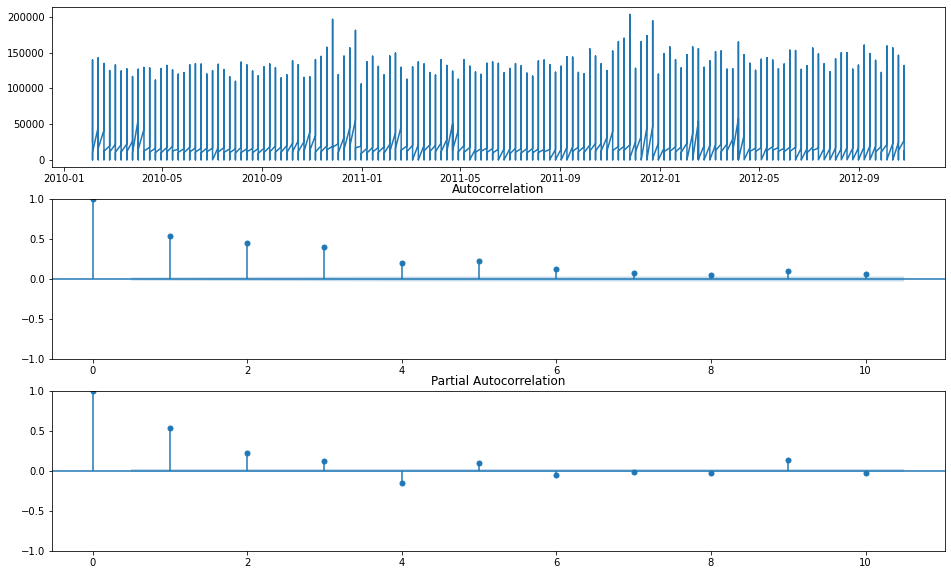

In [4]:
df=df_clean.copy()

# plots 
fig, axs = plt.subplots(3, 1,figsize=(16,10))
axs[0].plot(df['Weekly_Sales'])
sm.graphics.tsa.plot_acf(df.Weekly_Sales, lags=10, ax=axs[1]);
sm.graphics.tsa.plot_pacf(df.Weekly_Sales, lags=10, ax=axs[2]);

Question 1

1. Decide/describe if the series is stationary or not. Support your argument with AC&PAC functions
and by means of statistical tests. Explain which transformation you will use to render the series
stationary and ready for modelling.

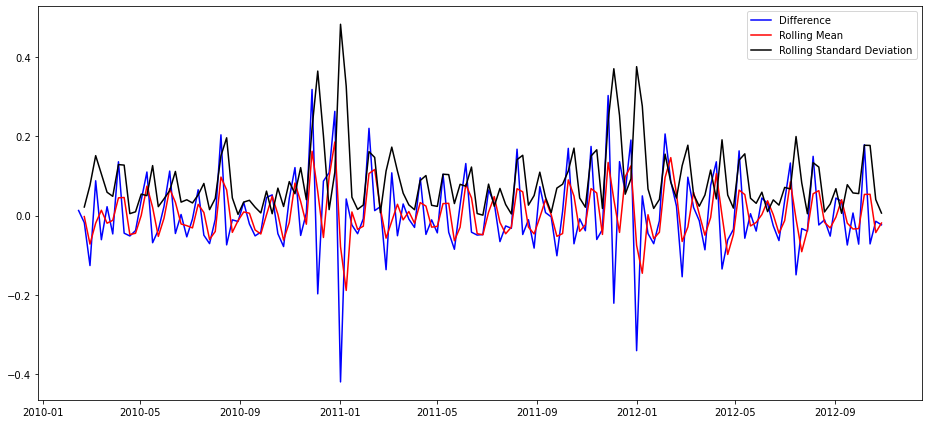

In [37]:
# Difference
#In this data, there are lots of same data values. So, I collect them together as weekly.
df_week = df.resample('W').mean() #resample data as weekly

#df_week_diff = df_week['Weekly_Sales'].diff().dropna() #creating difference values
df_week_diff = pd.DataFrame.pct_change(df_week['Weekly_Sales']).dropna()
# taking mean and std of differenced data
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

In [38]:
adfuller_test = adfuller(df_week_diff, autolag='AIC')
adfuller_output = pd.Series(adfuller_test[0:3], index=['ADF Statistic','p-value','#Lags Used'])
for key,value in adfuller_test[4].items():
    adfuller_output['Critical Value (%s)'%key] = value
print(adfuller_output)

ADF Statistic          -6.628176e+00
p-value                 5.804675e-09
#Lags Used              7.000000e+00
Critical Value (1%)    -3.480119e+00
Critical Value (5%)    -2.883362e+00
Critical Value (10%)   -2.578407e+00
dtype: float64


From the p-value = 5.804675e-09< α = 0.05 , we can say that our series is stationary.

d:\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


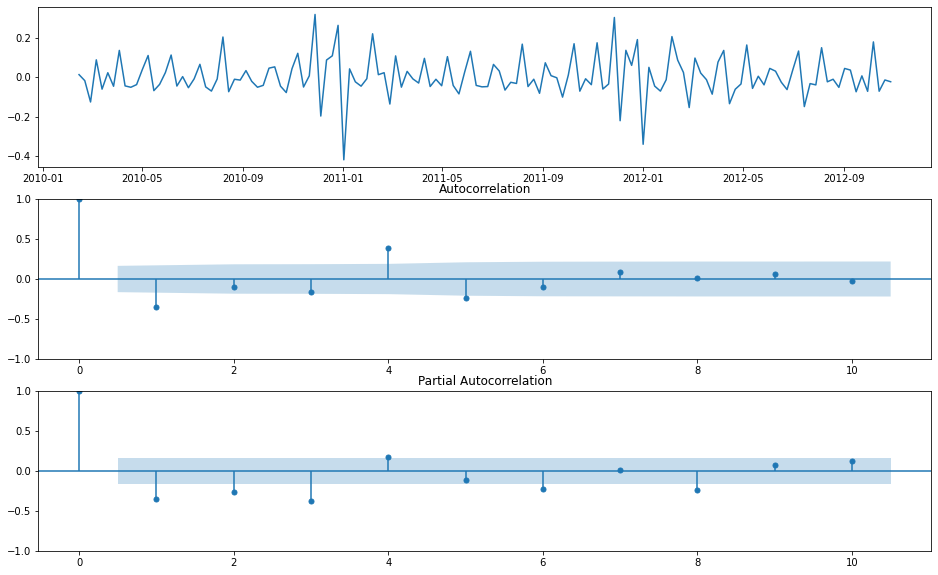

In [39]:
# plots 
fig, axs = plt.subplots(3, 1,figsize=(16,10))
axs[0].plot(df_week_diff)
sm.graphics.tsa.plot_acf(df_week_diff, lags=10, ax=axs[1]);
sm.graphics.tsa.plot_pacf(df_week_diff, lags=10, ax=axs[2]);

2. Take stationary series (from step 1), reserve the first 80% of the sample for estimation and
select an appropriate ARIMA model. Justify your choice.

In [40]:
train_data = df_week[:int(0.8*(len(df_week)))] 
test_data = df_week[int(0.8*(len(df_week))):]

In [41]:
#Train-Test Split
train_data_diff = df_week_diff [:int(0.8*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.8*(len(df_week_diff ))):]

In [15]:
!pip install pmdarima

  Using cached pmdarima-2.0.2-cp39-cp39-win_amd64.whl (572 kB)


In [42]:
from pmdarima import auto_arima
model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=-179.171, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=-205.252, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=-205.629, Time=0.27 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=-203.921, Time=0.43 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=-210.987, Time=0.45 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=-192.166, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=-202.624, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=-203.804, Time=0.47 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=-209.675, Time=0.45 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=-216.556, Time=0.73 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=-197.602, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=-203.817, Time=0.38 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=-221.887, Time=0.84 sec
 ARIMA(3,0,0)(0,0,0)

ARIMA(maxiter=200, order=(2, 0, 3), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

3. Use the model (from step 2) and perform 1-step-ahead forecasts for your series for the
remaining 20% of the sample

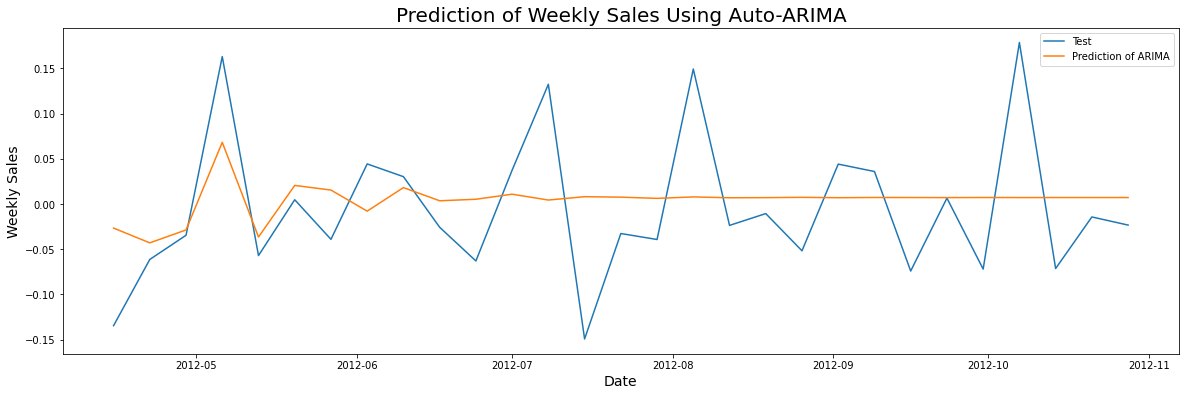

In [43]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()


the result of prediction is not so good, so I decided to try another model, ExponentialSmoothing which is used when data has trend, and it flattens the trend. The damped trend method adds a damping parameter so, the trend converges to a constant value in the future..

In [44]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

C:\Users\wang\AppData\Local\Temp/ipykernel_420/2918853493.py:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',


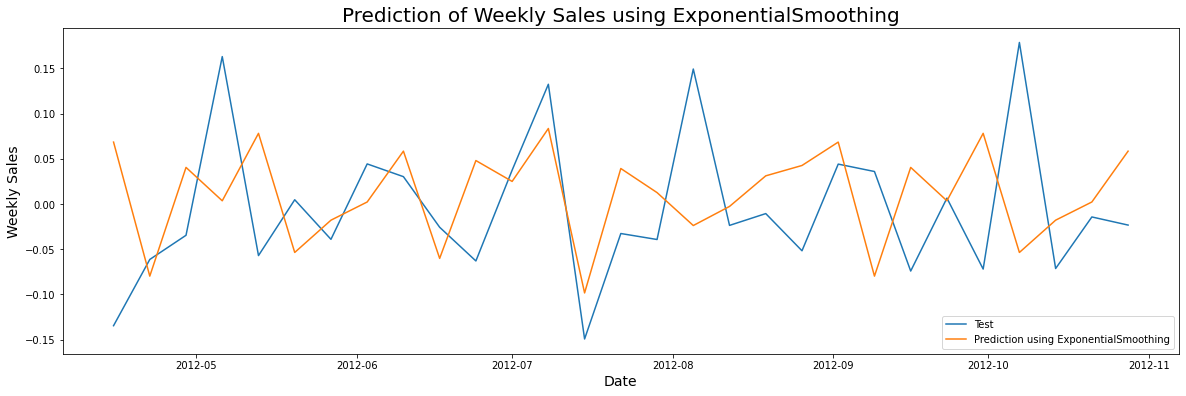

In [45]:
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.
y_pred = model_holt_winters.forecast(len(test_data_diff))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [46]:
# declare evaluation measures matrices


# calculate rmse, rmspe, mae 
rmse = sm.tools.eval_measures.rmse(test_data_diff,y_pred)
mae = sm.tools.eval_measures.meanabs(test_data_diff,y_pred)
rmspe = sm.tools.eval_measures.rmspe(test_data_diff,y_pred)

print("RMSE", rmse)
print("MAE",mae)

print("RMSPE", rmspe)

RMSE 0.0980272942858962
MAE 0.07744648674390717
RMSPE 28.454992049715038
